In [4]:
!pip install --upgrade fsspec==2024.10.0

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.1.0 requires fsspec[http]<=2024.9.0,>=2023.1.0, but you have fsspec 2024.10.0 which is incompatible.


In [5]:
!pip install "datasets==3.1.0" "fsspec<=2024.9.0,>=2023.1.0" "gcsfs<2024.10.0"

  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install datasets

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from sklearn.utils import resample, shuffle

C:\Users\Dua Zahra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load your datasets
d_path = r"C:\Users\Dua Zahra\Desktop\Results\d_tweets.csv"
non_d_path = r"C:\Users\Dua Zahra\Desktop\Results\non_d_tweets.csv"

d_tweet_df = pd.read_csv(d_path)
non_d_tweet_df = pd.read_csv(non_d_path)

# Remove empty rows
d_tweet_df = d_tweet_df[d_tweet_df['tweet'].notna()]
non_d_tweet_df = non_d_tweet_df[non_d_tweet_df['tweet'].notna()]

# Assign labels
non_d_tweet_df['label'] = 0
d_tweet_df['label'] = 1

# Combine datasets and shuffle
tweet_df = pd.concat([d_tweet_df[['tweet', 'label']], non_d_tweet_df[['tweet', 'label']]])
tweet_df = shuffle(tweet_df).reset_index(drop=True)

# Identify majority and minority classes
majority_class = tweet_df[tweet_df['label'] == tweet_df['label'].mode()[0]]
minority_class = tweet_df[tweet_df['label'] != tweet_df['label'].mode()[0]]

# Undersample the majority class
majority_undersampled = resample(majority_class,
                                 replace=False,    # sampling without replacement
                                 n_samples=len(minority_class),  # match minority class size
                                 random_state=42)  # reproducible results

# Combine the undersampled majority class with the minority class
tweet_df = pd.concat([majority_undersampled, minority_class])

# Shuffle the balanced dataset
tweet_df = shuffle(tweet_df).reset_index(drop=True)






FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Craib-Lab\\Desktop\\Wafa\\d_tweets.csv'

In [37]:
print(tweet_df['label'].value_counts())


label
0    3496
1    3496
Name: count, dtype: int64


In [43]:
# Split the dataset
train_data, val_data = train_test_split(tweet_df, test_size=0.2, stratify=tweet_df['label'], random_state=42)


In [44]:
# Convert Pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)


In [45]:
# Load pre-trained BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


In [46]:
# Define a preprocessing function
def preprocess_function(examples):
    return tokenizer(
        examples['tweet'],  # Input text
        truncation=True,    # Truncate sequences longer than `max_length`
        padding="max_length",       # Pad sequences to the same length
        max_length=128      # Set the maximum token length
    )

# Apply preprocessing to the datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 1399/1399 [00:00<00:00, 6973.14 examples/s]


In [47]:
# Step 6: Load Pretrained BERT Model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
# Define training arguments with epochs and batch size
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=20,             # number of epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,                # log every 10 steps
    eval_strategy="epoch",           # evaluate after each epoch
    save_strategy="epoch",           # save model after each epoch
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model='eval_loss',  # Specify the metric to use for the best model
)

# Define callbacks
from transformers import EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)  # Early stopping callback

# Define the Trainer with callbacks
trainer = Trainer(
    model=model,                     # the model to train
    args=training_args,              # training arguments
    train_dataset=train_dataset,     # training dataset
    eval_dataset=val_dataset,        # evaluation dataset
    callbacks=[early_stopping]       # Add early stopping callback
)

# Train the model
trainer.train()



  0%|          | 10/7000 [00:40<7:45:32,  4.00s/it]

{'loss': 0.767, 'grad_norm': 5.906614780426025, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.03}


  0%|          | 20/7000 [01:20<7:44:02,  3.99s/it]

{'loss': 0.7814, 'grad_norm': 13.202493667602539, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.06}


  0%|          | 30/7000 [02:01<7:43:39,  3.99s/it]

{'loss': 0.6817, 'grad_norm': 6.659938335418701, 'learning_rate': 3e-06, 'epoch': 0.09}


  1%|          | 40/7000 [02:42<7:57:22,  4.12s/it]

{'loss': 0.6662, 'grad_norm': 8.270463943481445, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.11}


  1%|          | 50/7000 [03:23<7:57:19,  4.12s/it]

{'loss': 0.5612, 'grad_norm': 3.8468732833862305, 'learning_rate': 5e-06, 'epoch': 0.14}


  1%|          | 60/7000 [04:04<7:55:48,  4.11s/it]

{'loss': 0.5356, 'grad_norm': 4.781904220581055, 'learning_rate': 6e-06, 'epoch': 0.17}


  1%|          | 70/7000 [04:45<7:51:42,  4.08s/it]

{'loss': 0.516, 'grad_norm': 13.124187469482422, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.2}


  1%|          | 80/7000 [05:25<7:50:34,  4.08s/it]

{'loss': 0.4747, 'grad_norm': 6.442173480987549, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.23}


  1%|▏         | 90/7000 [06:05<7:37:55,  3.98s/it]

{'loss': 0.4468, 'grad_norm': 4.848288536071777, 'learning_rate': 9e-06, 'epoch': 0.26}


  1%|▏         | 100/7000 [06:45<7:48:05,  4.07s/it]

{'loss': 0.3843, 'grad_norm': 11.903691291809082, 'learning_rate': 1e-05, 'epoch': 0.29}


  2%|▏         | 110/7000 [07:26<7:44:12,  4.04s/it]

{'loss': 0.3827, 'grad_norm': 5.378190994262695, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.31}


  2%|▏         | 120/7000 [08:06<7:35:56,  3.98s/it]

{'loss': 0.2445, 'grad_norm': 9.448256492614746, 'learning_rate': 1.2e-05, 'epoch': 0.34}


  2%|▏         | 130/7000 [08:45<7:27:48,  3.91s/it]

{'loss': 0.3528, 'grad_norm': 33.667144775390625, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.37}


  2%|▏         | 140/7000 [09:25<7:35:35,  3.98s/it]

{'loss': 0.2893, 'grad_norm': 21.579221725463867, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.4}


  2%|▏         | 150/7000 [10:05<7:40:58,  4.04s/it]

{'loss': 0.2284, 'grad_norm': 11.680022239685059, 'learning_rate': 1.5e-05, 'epoch': 0.43}


  2%|▏         | 160/7000 [10:46<7:36:03,  4.00s/it]

{'loss': 0.3176, 'grad_norm': 2.5407118797302246, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.46}


  2%|▏         | 170/7000 [11:27<7:30:21,  3.96s/it]

{'loss': 0.3592, 'grad_norm': 14.1685209274292, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.49}


  3%|▎         | 180/7000 [12:07<7:32:06,  3.98s/it]

{'loss': 0.272, 'grad_norm': 2.632683515548706, 'learning_rate': 1.8e-05, 'epoch': 0.51}


  3%|▎         | 190/7000 [12:48<7:48:12,  4.13s/it]

{'loss': 0.2785, 'grad_norm': 8.385099411010742, 'learning_rate': 1.9e-05, 'epoch': 0.54}


  3%|▎         | 200/7000 [13:30<7:50:16,  4.15s/it]

{'loss': 0.2098, 'grad_norm': 7.851673603057861, 'learning_rate': 2e-05, 'epoch': 0.57}


  3%|▎         | 210/7000 [14:11<7:48:51,  4.14s/it]

{'loss': 0.3195, 'grad_norm': 16.119630813598633, 'learning_rate': 2.1e-05, 'epoch': 0.6}


  3%|▎         | 220/7000 [14:52<7:47:10,  4.13s/it]

{'loss': 0.205, 'grad_norm': 8.190470695495605, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.63}


  3%|▎         | 230/7000 [15:34<7:47:01,  4.14s/it]

{'loss': 0.2101, 'grad_norm': 3.076721429824829, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.66}


  3%|▎         | 240/7000 [16:15<7:45:05,  4.13s/it]

{'loss': 0.2679, 'grad_norm': 3.6394853591918945, 'learning_rate': 2.4e-05, 'epoch': 0.69}


  4%|▎         | 250/7000 [16:56<7:44:12,  4.13s/it]

{'loss': 0.2678, 'grad_norm': 10.131831169128418, 'learning_rate': 2.5e-05, 'epoch': 0.71}


  4%|▎         | 260/7000 [17:38<7:46:21,  4.15s/it]

{'loss': 0.2388, 'grad_norm': 11.490111351013184, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.74}


  4%|▍         | 270/7000 [18:19<7:45:23,  4.15s/it]

{'loss': 0.3044, 'grad_norm': 7.959514141082764, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.77}


  4%|▍         | 280/7000 [19:01<7:47:41,  4.18s/it]

{'loss': 0.2344, 'grad_norm': 9.647177696228027, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.8}


  4%|▍         | 290/7000 [19:42<7:41:51,  4.13s/it]

{'loss': 0.3277, 'grad_norm': 12.838431358337402, 'learning_rate': 2.9e-05, 'epoch': 0.83}


  4%|▍         | 300/7000 [20:24<7:44:06,  4.16s/it]

{'loss': 0.2617, 'grad_norm': 6.592728137969971, 'learning_rate': 3e-05, 'epoch': 0.86}


  4%|▍         | 310/7000 [21:06<7:41:28,  4.14s/it]

{'loss': 0.2956, 'grad_norm': 29.82563591003418, 'learning_rate': 3.1e-05, 'epoch': 0.89}


  5%|▍         | 320/7000 [21:48<7:47:24,  4.20s/it]

{'loss': 0.2734, 'grad_norm': 15.81421947479248, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.91}


  5%|▍         | 330/7000 [22:29<7:29:53,  4.05s/it]

{'loss': 0.235, 'grad_norm': 4.580228805541992, 'learning_rate': 3.3e-05, 'epoch': 0.94}


  5%|▍         | 340/7000 [23:11<7:34:14,  4.09s/it]

{'loss': 0.1987, 'grad_norm': 4.032841205596924, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.97}


  5%|▌         | 350/7000 [23:49<6:33:39,  3.55s/it]

{'loss': 0.2347, 'grad_norm': 8.506595611572266, 'learning_rate': 3.5e-05, 'epoch': 1.0}



  5%|▌         | 350/7000 [25:26<6:33:39,  3.55s/it]

{'eval_loss': 0.3159969449043274, 'eval_runtime': 96.7561, 'eval_samples_per_second': 14.459, 'eval_steps_per_second': 0.227, 'epoch': 1.0}


  5%|▌         | 360/7000 [26:14<9:57:06,  5.40s/it] 

{'loss': 0.2113, 'grad_norm': 3.24102783203125, 'learning_rate': 3.6e-05, 'epoch': 1.03}


  5%|▌         | 370/7000 [26:56<7:45:29,  4.21s/it]

{'loss': 0.2262, 'grad_norm': 10.75942325592041, 'learning_rate': 3.7e-05, 'epoch': 1.06}


  5%|▌         | 380/7000 [27:37<7:38:01,  4.15s/it]

{'loss': 0.2713, 'grad_norm': 11.834856986999512, 'learning_rate': 3.8e-05, 'epoch': 1.09}


  6%|▌         | 390/7000 [28:18<7:30:05,  4.09s/it]

{'loss': 0.1489, 'grad_norm': 6.254356861114502, 'learning_rate': 3.9000000000000006e-05, 'epoch': 1.11}


  6%|▌         | 400/7000 [28:59<7:31:07,  4.10s/it]

{'loss': 0.1499, 'grad_norm': 3.5297653675079346, 'learning_rate': 4e-05, 'epoch': 1.14}


  6%|▌         | 410/7000 [29:40<7:32:29,  4.12s/it]

{'loss': 0.1605, 'grad_norm': 0.8826077580451965, 'learning_rate': 4.1e-05, 'epoch': 1.17}


  6%|▌         | 420/7000 [30:22<7:38:34,  4.18s/it]

{'loss': 0.1037, 'grad_norm': 28.832319259643555, 'learning_rate': 4.2e-05, 'epoch': 1.2}


  6%|▌         | 430/7000 [31:03<7:32:43,  4.13s/it]

{'loss': 0.1608, 'grad_norm': 3.9388675689697266, 'learning_rate': 4.3e-05, 'epoch': 1.23}


  6%|▋         | 440/7000 [31:44<7:26:22,  4.08s/it]

{'loss': 0.2436, 'grad_norm': 5.344732761383057, 'learning_rate': 4.4000000000000006e-05, 'epoch': 1.26}


  6%|▋         | 450/7000 [32:26<7:33:40,  4.16s/it]

{'loss': 0.1211, 'grad_norm': 3.9513163566589355, 'learning_rate': 4.5e-05, 'epoch': 1.29}


  7%|▋         | 460/7000 [33:08<7:30:49,  4.14s/it]

{'loss': 0.1475, 'grad_norm': 2.469552516937256, 'learning_rate': 4.600000000000001e-05, 'epoch': 1.31}


  7%|▋         | 470/7000 [33:49<7:28:26,  4.12s/it]

{'loss': 0.1499, 'grad_norm': 14.929764747619629, 'learning_rate': 4.7e-05, 'epoch': 1.34}


  7%|▋         | 480/7000 [34:31<7:30:00,  4.14s/it]

{'loss': 0.1037, 'grad_norm': 2.903747797012329, 'learning_rate': 4.8e-05, 'epoch': 1.37}


  7%|▋         | 490/7000 [35:12<7:33:42,  4.18s/it]

{'loss': 0.2122, 'grad_norm': 3.8378305435180664, 'learning_rate': 4.9e-05, 'epoch': 1.4}


  7%|▋         | 500/7000 [35:54<7:21:59,  4.08s/it]

{'loss': 0.2149, 'grad_norm': 0.9297227263450623, 'learning_rate': 5e-05, 'epoch': 1.43}


  7%|▋         | 510/7000 [36:36<7:32:06,  4.18s/it]

{'loss': 0.1889, 'grad_norm': 12.685358047485352, 'learning_rate': 4.992307692307693e-05, 'epoch': 1.46}


  7%|▋         | 520/7000 [37:16<7:07:09,  3.96s/it]

{'loss': 0.1509, 'grad_norm': 5.8604254722595215, 'learning_rate': 4.984615384615385e-05, 'epoch': 1.49}


  8%|▊         | 530/7000 [37:56<7:14:22,  4.03s/it]

{'loss': 0.2514, 'grad_norm': 9.89688777923584, 'learning_rate': 4.9769230769230775e-05, 'epoch': 1.51}


  8%|▊         | 540/7000 [38:38<7:31:53,  4.20s/it]

{'loss': 0.2228, 'grad_norm': 1.7273783683776855, 'learning_rate': 4.969230769230769e-05, 'epoch': 1.54}


  8%|▊         | 550/7000 [39:19<7:22:26,  4.12s/it]

{'loss': 0.2395, 'grad_norm': 5.987757205963135, 'learning_rate': 4.961538461538462e-05, 'epoch': 1.57}


  8%|▊         | 560/7000 [40:01<7:27:00,  4.16s/it]

{'loss': 0.2355, 'grad_norm': 5.0225090980529785, 'learning_rate': 4.953846153846154e-05, 'epoch': 1.6}


  8%|▊         | 570/7000 [40:43<7:29:36,  4.20s/it]

{'loss': 0.1232, 'grad_norm': 1.6499780416488647, 'learning_rate': 4.9461538461538466e-05, 'epoch': 1.63}


  8%|▊         | 580/7000 [41:25<7:27:03,  4.18s/it]

{'loss': 0.2344, 'grad_norm': 6.4179606437683105, 'learning_rate': 4.9384615384615384e-05, 'epoch': 1.66}


  8%|▊         | 590/7000 [42:06<7:23:21,  4.15s/it]

{'loss': 0.2665, 'grad_norm': 3.1146631240844727, 'learning_rate': 4.930769230769231e-05, 'epoch': 1.69}


  9%|▊         | 600/7000 [42:48<7:33:50,  4.25s/it]

{'loss': 0.1495, 'grad_norm': 12.412229537963867, 'learning_rate': 4.923076923076924e-05, 'epoch': 1.71}


  9%|▊         | 610/7000 [43:30<7:18:39,  4.12s/it]

{'loss': 0.1531, 'grad_norm': 6.5366716384887695, 'learning_rate': 4.9153846153846157e-05, 'epoch': 1.74}


  9%|▉         | 620/7000 [44:11<7:20:11,  4.14s/it]

{'loss': 0.2035, 'grad_norm': 8.880768775939941, 'learning_rate': 4.907692307692308e-05, 'epoch': 1.77}


  9%|▉         | 630/7000 [44:53<7:25:59,  4.20s/it]

{'loss': 0.1866, 'grad_norm': 11.78664779663086, 'learning_rate': 4.9e-05, 'epoch': 1.8}


  9%|▉         | 640/7000 [45:35<7:18:54,  4.14s/it]

{'loss': 0.161, 'grad_norm': 3.04228138923645, 'learning_rate': 4.892307692307693e-05, 'epoch': 1.83}


  9%|▉         | 650/7000 [46:17<7:17:24,  4.13s/it]

{'loss': 0.1357, 'grad_norm': 10.272218704223633, 'learning_rate': 4.884615384615385e-05, 'epoch': 1.86}


  9%|▉         | 660/7000 [46:58<7:14:00,  4.11s/it]

{'loss': 0.2065, 'grad_norm': 0.7231526374816895, 'learning_rate': 4.876923076923077e-05, 'epoch': 1.89}


 10%|▉         | 670/7000 [47:39<7:20:35,  4.18s/it]

{'loss': 0.2654, 'grad_norm': 10.16421890258789, 'learning_rate': 4.8692307692307696e-05, 'epoch': 1.91}


 10%|▉         | 680/7000 [48:21<7:18:00,  4.16s/it]

{'loss': 0.1709, 'grad_norm': 3.9167447090148926, 'learning_rate': 4.861538461538462e-05, 'epoch': 1.94}


 10%|▉         | 690/7000 [49:02<7:12:02,  4.11s/it]

{'loss': 0.1363, 'grad_norm': 0.26649320125579834, 'learning_rate': 4.853846153846154e-05, 'epoch': 1.97}


 10%|█         | 700/7000 [49:42<6:17:53,  3.60s/it]

{'loss': 0.2595, 'grad_norm': 1.2536038160324097, 'learning_rate': 4.846153846153846e-05, 'epoch': 2.0}



 10%|█         | 700/7000 [51:20<6:17:53,  3.60s/it]

{'eval_loss': 0.19670000672340393, 'eval_runtime': 97.8328, 'eval_samples_per_second': 14.3, 'eval_steps_per_second': 0.225, 'epoch': 2.0}


 10%|█         | 710/7000 [52:06<9:16:53,  5.31s/it] 

{'loss': 0.0514, 'grad_norm': 0.5657281279563904, 'learning_rate': 4.8384615384615386e-05, 'epoch': 2.03}


 10%|█         | 720/7000 [52:47<7:13:23,  4.14s/it]

{'loss': 0.0642, 'grad_norm': 1.5351029634475708, 'learning_rate': 4.830769230769231e-05, 'epoch': 2.06}


 10%|█         | 730/7000 [53:26<6:59:03,  4.01s/it]

{'loss': 0.0583, 'grad_norm': 12.751524925231934, 'learning_rate': 4.8230769230769235e-05, 'epoch': 2.09}


 11%|█         | 740/7000 [54:06<6:42:25,  3.86s/it]

{'loss': 0.1015, 'grad_norm': 0.9367976188659668, 'learning_rate': 4.815384615384615e-05, 'epoch': 2.11}


 11%|█         | 750/7000 [54:46<6:54:40,  3.98s/it]

{'loss': 0.1239, 'grad_norm': 0.8511933088302612, 'learning_rate': 4.8076923076923084e-05, 'epoch': 2.14}


 11%|█         | 760/7000 [55:25<6:45:07,  3.90s/it]

{'loss': 0.0981, 'grad_norm': 1.267991542816162, 'learning_rate': 4.8e-05, 'epoch': 2.17}


 11%|█         | 770/7000 [56:04<6:50:24,  3.95s/it]

{'loss': 0.0447, 'grad_norm': 0.05960279703140259, 'learning_rate': 4.7923076923076926e-05, 'epoch': 2.2}


 11%|█         | 780/7000 [56:44<6:44:11,  3.90s/it]

{'loss': 0.0933, 'grad_norm': 24.52821159362793, 'learning_rate': 4.784615384615384e-05, 'epoch': 2.23}


 11%|█▏        | 790/7000 [57:24<6:48:51,  3.95s/it]

{'loss': 0.0631, 'grad_norm': 0.1858530342578888, 'learning_rate': 4.7769230769230774e-05, 'epoch': 2.26}


 11%|█▏        | 800/7000 [58:03<6:50:14,  3.97s/it]

{'loss': 0.1151, 'grad_norm': 0.2999497950077057, 'learning_rate': 4.76923076923077e-05, 'epoch': 2.29}


 12%|█▏        | 810/7000 [58:42<6:45:16,  3.93s/it]

{'loss': 0.1127, 'grad_norm': 11.27657699584961, 'learning_rate': 4.7615384615384616e-05, 'epoch': 2.31}


 12%|█▏        | 820/7000 [59:23<6:54:13,  4.02s/it]

{'loss': 0.1482, 'grad_norm': 26.290266036987305, 'learning_rate': 4.753846153846154e-05, 'epoch': 2.34}


 12%|█▏        | 830/7000 [1:00:03<6:55:31,  4.04s/it]

{'loss': 0.2003, 'grad_norm': 3.559096336364746, 'learning_rate': 4.7461538461538465e-05, 'epoch': 2.37}


 12%|█▏        | 840/7000 [1:00:42<6:36:41,  3.86s/it]

{'loss': 0.0961, 'grad_norm': 11.814375877380371, 'learning_rate': 4.738461538461539e-05, 'epoch': 2.4}


 12%|█▏        | 850/7000 [1:01:21<6:47:08,  3.97s/it]

{'loss': 0.14, 'grad_norm': 1.8853659629821777, 'learning_rate': 4.730769230769231e-05, 'epoch': 2.43}


 12%|█▏        | 860/7000 [1:02:01<6:44:32,  3.95s/it]

{'loss': 0.0832, 'grad_norm': 33.18769454956055, 'learning_rate': 4.723076923076923e-05, 'epoch': 2.46}


 12%|█▏        | 870/7000 [1:02:41<6:59:10,  4.10s/it]

{'loss': 0.0757, 'grad_norm': 0.1405530720949173, 'learning_rate': 4.7153846153846155e-05, 'epoch': 2.49}


 13%|█▎        | 880/7000 [1:03:21<6:40:48,  3.93s/it]

{'loss': 0.1875, 'grad_norm': 18.89300537109375, 'learning_rate': 4.707692307692308e-05, 'epoch': 2.51}


 13%|█▎        | 890/7000 [1:04:01<6:39:57,  3.93s/it]

{'loss': 0.0429, 'grad_norm': 0.09450902044773102, 'learning_rate': 4.7e-05, 'epoch': 2.54}


 13%|█▎        | 900/7000 [1:04:41<6:47:12,  4.01s/it]

{'loss': 0.1284, 'grad_norm': 19.639816284179688, 'learning_rate': 4.692307692307693e-05, 'epoch': 2.57}


 13%|█▎        | 910/7000 [1:05:21<6:56:04,  4.10s/it]

{'loss': 0.0597, 'grad_norm': 0.11698174476623535, 'learning_rate': 4.684615384615385e-05, 'epoch': 2.6}


 13%|█▎        | 920/7000 [1:06:00<6:27:47,  3.83s/it]

{'loss': 0.0646, 'grad_norm': 1.3738068342208862, 'learning_rate': 4.676923076923077e-05, 'epoch': 2.63}


 13%|█▎        | 930/7000 [1:06:40<6:34:12,  3.90s/it]

{'loss': 0.0514, 'grad_norm': 0.05223402753472328, 'learning_rate': 4.6692307692307695e-05, 'epoch': 2.66}


 13%|█▎        | 940/7000 [1:07:20<6:45:14,  4.01s/it]

{'loss': 0.0621, 'grad_norm': 10.47146224975586, 'learning_rate': 4.661538461538462e-05, 'epoch': 2.69}


 14%|█▎        | 950/7000 [1:07:59<6:34:52,  3.92s/it]

{'loss': 0.0346, 'grad_norm': 0.03761093318462372, 'learning_rate': 4.653846153846154e-05, 'epoch': 2.71}


 14%|█▎        | 960/7000 [1:08:39<6:39:17,  3.97s/it]

{'loss': 0.0749, 'grad_norm': 0.02385851927101612, 'learning_rate': 4.646153846153846e-05, 'epoch': 2.74}


 14%|█▍        | 970/7000 [1:09:18<6:35:04,  3.93s/it]

{'loss': 0.1232, 'grad_norm': 0.20485173165798187, 'learning_rate': 4.6384615384615385e-05, 'epoch': 2.77}


 14%|█▍        | 980/7000 [1:09:57<6:30:56,  3.90s/it]

{'loss': 0.0583, 'grad_norm': 0.4051288962364197, 'learning_rate': 4.630769230769231e-05, 'epoch': 2.8}


 14%|█▍        | 990/7000 [1:10:37<6:27:34,  3.87s/it]

{'loss': 0.0269, 'grad_norm': 0.07680843025445938, 'learning_rate': 4.6230769230769234e-05, 'epoch': 2.83}


 14%|█▍        | 1000/7000 [1:11:16<6:36:38,  3.97s/it]

{'loss': 0.0451, 'grad_norm': 0.2556135058403015, 'learning_rate': 4.615384615384616e-05, 'epoch': 2.86}


 14%|█▍        | 1010/7000 [1:11:56<6:26:57,  3.88s/it]

{'loss': 0.0942, 'grad_norm': 1.1550285816192627, 'learning_rate': 4.6076923076923076e-05, 'epoch': 2.89}


 15%|█▍        | 1020/7000 [1:12:35<6:34:14,  3.96s/it]

{'loss': 0.29, 'grad_norm': 6.056210517883301, 'learning_rate': 4.600000000000001e-05, 'epoch': 2.91}


 15%|█▍        | 1030/7000 [1:13:16<6:50:19,  4.12s/it]

{'loss': 0.1527, 'grad_norm': 0.2486341893672943, 'learning_rate': 4.5923076923076924e-05, 'epoch': 2.94}


 15%|█▍        | 1040/7000 [1:13:56<6:28:40,  3.91s/it]

{'loss': 0.0457, 'grad_norm': 0.2828836739063263, 'learning_rate': 4.584615384615385e-05, 'epoch': 2.97}


 15%|█▌        | 1050/7000 [1:14:33<5:35:21,  3.38s/it]

{'loss': 0.1483, 'grad_norm': 37.32411193847656, 'learning_rate': 4.576923076923077e-05, 'epoch': 3.0}



 15%|█▌        | 1050/7000 [1:16:08<5:35:21,  3.38s/it]

{'eval_loss': 0.26809361577033997, 'eval_runtime': 94.3951, 'eval_samples_per_second': 14.821, 'eval_steps_per_second': 0.233, 'epoch': 3.0}


 15%|█▌        | 1060/7000 [1:16:55<8:54:16,  5.40s/it] 

{'loss': 0.0042, 'grad_norm': 0.04490601271390915, 'learning_rate': 4.56923076923077e-05, 'epoch': 3.03}


 15%|█▌        | 1070/7000 [1:17:37<6:55:18,  4.20s/it]

{'loss': 0.0714, 'grad_norm': 2.940173387527466, 'learning_rate': 4.5615384615384615e-05, 'epoch': 3.06}


 15%|█▌        | 1080/7000 [1:18:19<6:52:52,  4.18s/it]

{'loss': 0.0427, 'grad_norm': 0.03215669095516205, 'learning_rate': 4.553846153846154e-05, 'epoch': 3.09}


 16%|█▌        | 1090/7000 [1:19:00<6:49:16,  4.16s/it]

{'loss': 0.0743, 'grad_norm': 76.63941955566406, 'learning_rate': 4.5461538461538464e-05, 'epoch': 3.11}


 16%|█▌        | 1100/7000 [1:19:42<6:50:51,  4.18s/it]

{'loss': 0.0127, 'grad_norm': 1.7348394393920898, 'learning_rate': 4.538461538461539e-05, 'epoch': 3.14}


 16%|█▌        | 1110/7000 [1:20:24<6:49:25,  4.17s/it]

{'loss': 0.0549, 'grad_norm': 0.05939820036292076, 'learning_rate': 4.530769230769231e-05, 'epoch': 3.17}


 16%|█▌        | 1120/7000 [1:21:06<6:49:10,  4.18s/it]

{'loss': 0.0463, 'grad_norm': 0.027712224051356316, 'learning_rate': 4.523076923076923e-05, 'epoch': 3.2}


 16%|█▌        | 1130/7000 [1:21:48<6:48:59,  4.18s/it]

{'loss': 0.0198, 'grad_norm': 0.023480571806430817, 'learning_rate': 4.515384615384616e-05, 'epoch': 3.23}


 16%|█▋        | 1140/7000 [1:22:30<6:47:33,  4.17s/it]

{'loss': 0.0955, 'grad_norm': 0.019298028200864792, 'learning_rate': 4.507692307692308e-05, 'epoch': 3.26}


 16%|█▋        | 1150/7000 [1:23:12<6:52:52,  4.23s/it]

{'loss': 0.0321, 'grad_norm': 0.022326700389385223, 'learning_rate': 4.5e-05, 'epoch': 3.29}


 17%|█▋        | 1160/7000 [1:23:54<6:46:35,  4.18s/it]

{'loss': 0.1159, 'grad_norm': 7.419642925262451, 'learning_rate': 4.492307692307692e-05, 'epoch': 3.31}


 17%|█▋        | 1170/7000 [1:24:36<6:47:23,  4.19s/it]

{'loss': 0.057, 'grad_norm': 1.3083503246307373, 'learning_rate': 4.484615384615385e-05, 'epoch': 3.34}


 17%|█▋        | 1180/7000 [1:25:18<6:48:30,  4.21s/it]

{'loss': 0.1218, 'grad_norm': 20.2840518951416, 'learning_rate': 4.476923076923077e-05, 'epoch': 3.37}


 17%|█▋        | 1190/7000 [1:26:00<6:44:02,  4.17s/it]

{'loss': 0.0296, 'grad_norm': 0.07301413267850876, 'learning_rate': 4.4692307692307693e-05, 'epoch': 3.4}


 17%|█▋        | 1200/7000 [1:26:42<6:51:29,  4.26s/it]

{'loss': 0.0598, 'grad_norm': 1.0435307025909424, 'learning_rate': 4.461538461538462e-05, 'epoch': 3.43}


 17%|█▋        | 1210/7000 [1:27:23<6:30:57,  4.05s/it]

{'loss': 0.028, 'grad_norm': 0.037451792508363724, 'learning_rate': 4.453846153846154e-05, 'epoch': 3.46}


 17%|█▋        | 1220/7000 [1:28:02<6:17:58,  3.92s/it]

{'loss': 0.0561, 'grad_norm': 0.016872376203536987, 'learning_rate': 4.4461538461538466e-05, 'epoch': 3.49}


 18%|█▊        | 1230/7000 [1:28:41<6:16:49,  3.92s/it]

{'loss': 0.1211, 'grad_norm': 1.2394574880599976, 'learning_rate': 4.4384615384615384e-05, 'epoch': 3.51}


 18%|█▊        | 1240/7000 [1:29:21<6:22:12,  3.98s/it]

{'loss': 0.0583, 'grad_norm': 5.449286460876465, 'learning_rate': 4.430769230769231e-05, 'epoch': 3.54}


 18%|█▊        | 1250/7000 [1:30:01<6:24:39,  4.01s/it]

{'loss': 0.0571, 'grad_norm': 0.04459672048687935, 'learning_rate': 4.423076923076923e-05, 'epoch': 3.57}


 18%|█▊        | 1260/7000 [1:30:42<6:27:05,  4.05s/it]

{'loss': 0.0097, 'grad_norm': 0.04866623505949974, 'learning_rate': 4.415384615384616e-05, 'epoch': 3.6}


 18%|█▊        | 1270/7000 [1:31:21<6:16:15,  3.94s/it]

{'loss': 0.035, 'grad_norm': 0.029824763536453247, 'learning_rate': 4.4076923076923075e-05, 'epoch': 3.63}


 18%|█▊        | 1280/7000 [1:32:01<6:12:37,  3.91s/it]

{'loss': 0.1298, 'grad_norm': 4.559566974639893, 'learning_rate': 4.4000000000000006e-05, 'epoch': 3.66}


 18%|█▊        | 1290/7000 [1:32:40<6:28:24,  4.08s/it]

{'loss': 0.0217, 'grad_norm': 0.03557940945029259, 'learning_rate': 4.392307692307693e-05, 'epoch': 3.69}


 19%|█▊        | 1300/7000 [1:33:21<6:15:14,  3.95s/it]

{'loss': 0.0362, 'grad_norm': 0.10713654011487961, 'learning_rate': 4.384615384615385e-05, 'epoch': 3.71}


 19%|█▊        | 1310/7000 [1:34:01<6:17:37,  3.98s/it]

{'loss': 0.0433, 'grad_norm': 5.420701026916504, 'learning_rate': 4.376923076923077e-05, 'epoch': 3.74}


 19%|█▉        | 1320/7000 [1:34:40<6:15:34,  3.97s/it]

{'loss': 0.1076, 'grad_norm': 9.258920669555664, 'learning_rate': 4.3692307692307696e-05, 'epoch': 3.77}


 19%|█▉        | 1330/7000 [1:35:19<6:05:56,  3.87s/it]

{'loss': 0.0281, 'grad_norm': 0.6365267038345337, 'learning_rate': 4.361538461538462e-05, 'epoch': 3.8}


 19%|█▉        | 1340/7000 [1:35:59<6:07:27,  3.90s/it]

{'loss': 0.047, 'grad_norm': 0.1433454006910324, 'learning_rate': 4.353846153846154e-05, 'epoch': 3.83}


 19%|█▉        | 1350/7000 [1:36:38<6:16:56,  4.00s/it]

{'loss': 0.0187, 'grad_norm': 0.04006500542163849, 'learning_rate': 4.346153846153846e-05, 'epoch': 3.86}


 19%|█▉        | 1360/7000 [1:37:17<6:11:45,  3.95s/it]

{'loss': 0.1078, 'grad_norm': 10.125771522521973, 'learning_rate': 4.338461538461539e-05, 'epoch': 3.89}


 20%|█▉        | 1370/7000 [1:37:57<6:07:44,  3.92s/it]

{'loss': 0.0572, 'grad_norm': 0.03654664382338524, 'learning_rate': 4.330769230769231e-05, 'epoch': 3.91}


 20%|█▉        | 1380/7000 [1:38:35<6:00:56,  3.85s/it]

{'loss': 0.0327, 'grad_norm': 5.420797348022461, 'learning_rate': 4.323076923076923e-05, 'epoch': 3.94}


 20%|█▉        | 1390/7000 [1:39:14<5:59:29,  3.84s/it]

{'loss': 0.0838, 'grad_norm': 0.23825210332870483, 'learning_rate': 4.315384615384615e-05, 'epoch': 3.97}


 20%|██        | 1400/7000 [1:39:52<5:15:11,  3.38s/it]

{'loss': 0.0578, 'grad_norm': 0.07380777597427368, 'learning_rate': 4.3076923076923084e-05, 'epoch': 4.0}



 20%|██        | 1400/7000 [1:41:26<5:15:11,  3.38s/it]

{'eval_loss': 0.3696514964103699, 'eval_runtime': 94.1767, 'eval_samples_per_second': 14.855, 'eval_steps_per_second': 0.234, 'epoch': 4.0}


 20%|██        | 1400/7000 [1:41:32<6:46:10,  4.35s/it]

{'train_runtime': 6092.6261, 'train_samples_per_second': 18.36, 'train_steps_per_second': 1.149, 'train_loss': 0.17518574458147798, 'epoch': 4.0}


TrainOutput(global_step=1400, training_loss=0.17518574458147798, metrics={'train_runtime': 6092.6261, 'train_samples_per_second': 18.36, 'train_steps_per_second': 1.149, 'total_flos': 1471580132628480.0, 'train_loss': 0.17518574458147798, 'epoch': 4.0})

In [ ]:
# Save the model 
trainer.save_model("./depression_bert_model")
tokenizer.save_pretrained("./depression_bert_model")

('./depression_bert_model\\tokenizer_config.json',
 './depression_bert_model\\special_tokens_map.json',
 './depression_bert_model\\vocab.txt',
 './depression_bert_model\\added_tokens.json',
 './depression_bert_model\\tokenizer.json')

In [51]:
#Evaluate the Model
# Get predictions
from sklearn.metrics import classification_report

predictions = trainer.predict(val_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Generate classification report
print(classification_report(val_dataset['label'], predicted_labels, target_names=['non-depression', 'depression']))

100%|██████████| 22/22 [01:34<00:00,  4.28s/it]

                precision    recall  f1-score   support

non-depression       0.95      0.90      0.93       700
    depression       0.91      0.95      0.93       699

      accuracy                           0.93      1399
     macro avg       0.93      0.93      0.93      1399
  weighted avg       0.93      0.93      0.93      1399



100%|██████████| 22/22 [01:36<00:00,  4.38s/it]


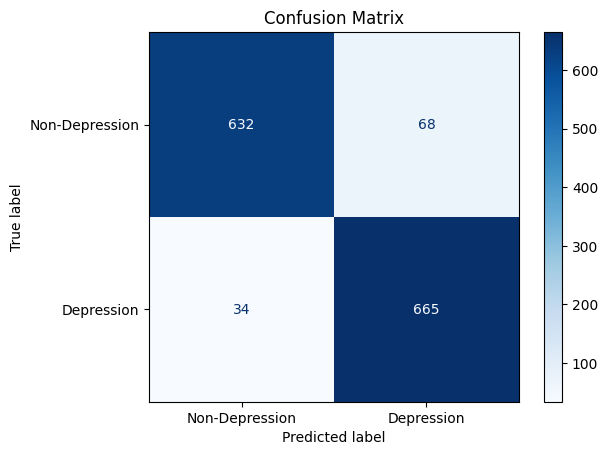

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# After the training is completed, you can make predictions on the validation set
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)  # Get predicted labels

# Extract true labels from val_dataset
y_true = np.array(val_dataset['label'])

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

#  confusion matrix 
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Depression', 'Depression'])
cm_display.plot(cmap='Blues')  
plt.title("Confusion Matrix")
plt.show()
